# Assignment 2 - Epipolar Geometry and 3D Reconstruction 

First name: Pascal
<br>
Last name: Gerig
<br>
Matriculation number: 16-104-721

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from data import load_homogeneous_coordinates
from utils import eight_points_algorithm, right_epipole, plot_epipolar_line

## Part I: The Eight Point Algorithm

### Load Data

In [2]:
data_dir = './merton_college/'
img1, img2, x1, x2 = load_homogeneous_coordinates(data_dir)

### Estimate the fundamental matrix F

In [3]:
F = eight_points_algorithm(x1, x2) 
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

Estimated fundamental matrix: 
[[-1.13842131e-09 -3.55063867e-07  1.46207354e-04]
 [ 1.07949189e-06  4.57307917e-08 -4.05769576e-03]
 [-4.48937328e-04  3.80280565e-03  1.59619094e-01]]


# Plot epipoles and epipolar lines

In [4]:
# compute the epipole
# TODO: implement this function
e = right_epipole(F)  

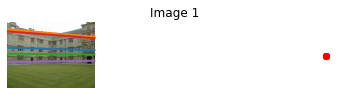

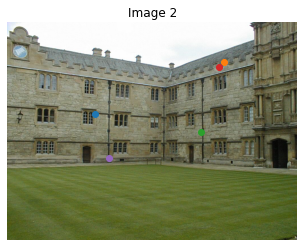

In [5]:
plt.figure()
plt.imshow(img1)
plt.title('Image 1')

# plot each line individually, this gives nice colors
for i in range(100, 105): 
    plot_epipolar_line(img1, F.T, x2[:, i], e)

plt.axis('off')
plt.figure()
plt.imshow(img2)
plt.title('Image 2')

# plot each point individually, this gives same colors as the lines 
for i in range(100, 105):
    plt.plot(x2[0, i], x2[1, i], 'o')
    plt.axis('off')

<IPython.core.display.Javascript object>


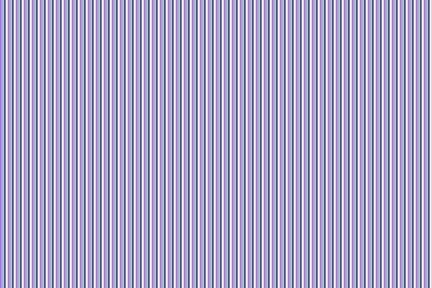

<IPython.core.display.Javascript object>


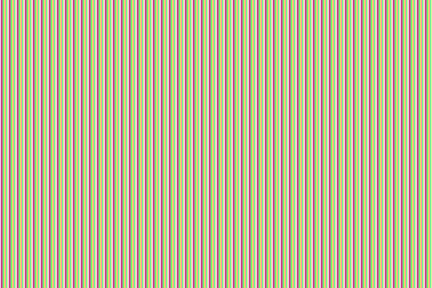

In [6]:
%matplotlib notebook
from ipywidgets import *

e2 = right_epipole(F.T)

fig, ax = plt.subplots()
ax.imshow(img1)

fig2, ax2 = plt.subplots()
ax2.imshow(img2)

def onclick(event):
    ax.plot(event.xdata, event.ydata, 'o')
    plot_epipolar_line(img2, F, np.array([event.xdata, event.ydata, 1]), e2, ax2)
    ax2.imshow(img2)

cid = fig.canvas.mpl_connect('button_press_event', onclick)